# **RNA Classification - Pierre Pauchet**

# Setup

Welcome to this notebook. This is a project I was assigned to complete during an interview process. 

The dataset is comprised of RNA-sequencing data taken from the blood of some thousand individuals, either healthy of suffering from rheumatoid arthrosis (RA) or Systemic Lupus Erythematosus (SLE) \
I was tasked to :
* Create a machine learning model that predicts a patient diagnosis given an individual's RNA data. The model should classify RA vs SLE vs healthy patients.
* Based on the predictive model I developed, determine which genes are main drivers of the diseases, and identify gene expression patterns leading to a higher chance of having each condition \

Keep in mind that the following project was completed in approximately **5 hours**.

In [261]:
## Dependencies
import torch 
import gc
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchmetrics import F1Score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image

In [262]:
## Hyperparameters 
EPOCHS=500
HIDDEN_UNITS=150
CLASSES=3
SEED=55
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

In [263]:
## Device agnostic coding 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [264]:
## Importing the data from raw files
ra_train_data=pd.read_csv("ra_train_data.tsv", sep= "\t")
ra_test_data=pd.read_csv("ra_test_data.tsv", sep= "\t")
healthy_train_data=pd.read_csv("healthy_train_data.tsv", sep= "\t")
healthy_test_data=pd.read_csv("healthy_test_data.tsv", sep= "\t")
sle_test_data=pd.read_csv("sle_test_data.tsv", sep= "\t")
sle_train_data=pd.read_csv("sle_train_data.tsv", sep= "\t")

# Data Processing, cleaning and visualisation
The first step in any data-driven project. Let us begin by labelling data. Healthy patients will be assigned the number 0, one that suffer respectively from RA and SLE will be assigned to 1 and 2.

In [265]:
# Labelling our data
ra_train_data["label"]=1
ra_test_data["label"]=1
healthy_train_data["label"]=0
healthy_test_data["label"]=0
sle_train_data["label"]=2
sle_test_data["label"]=2
sle_train_data.head()

,Unnamed: 0,DDX11L1,WASH7P,MIR6859-1,MIR1302-2HG,MIR1302-2,FAM138A,OR4F5,WASH9P,LOC729737,...,TRNH,TRNS2,TRNL2,ND5,ND6,TRNE,CYTB,TRNT,TRNP,label
0,GSE63755_GSM1556699,0.0,5.085,4.574,0.0,0.0,0.0,0.0,0.0,0.0,...,27.74,38.52,31.00,1016.0,1015.0,606.1,1110.0,64.89,120.30,2
1,GSE63755_GSM1556700,0.0,5.090,4.004,0.0,0.0,0.0,0.0,0.0,0.0,...,30.16,42.52,29.31,1389.0,1458.0,777.6,1715.0,83.09,135.60,2
2,GSE63755_GSM1556701,0.0,7.666,4.897,0.0,0.0,0.0,0.0,0.0,0.0,...,33.78,43.61,29.84,524.9,599.5,280.3,808.0,17.89,24.93,2
3,GSE63755_GSM1556702,0.0,4.574,3.967,0.0,0.0,0.0,0.0,0.0,0.0,...,51.72,68.58,49.68,1703.0,1660.0,946.3,1823.0,109.70,168.40,2
4,GSE63755_GSM1556703,0.0,6.321,4.730,0.0,0.0,0.0,0.0,0.0,0.0,...,40.86,49.07,35.98,1244.0,1258.0,700.1,1466.0,92.31,160.60,2


In [266]:
## Data Preprocessing and visualisation
# Scanning for doublons 
np.max(ra_train_data.iloc[:,0].value_counts()), np.max(ra_test_data.iloc[:,0].value_counts()),np.max(healthy_train_data.iloc[:,0].value_counts()),np.max(healthy_test_data.iloc[:,0].value_counts()),np.max(sle_train_data.iloc[:,0].value_counts()),np.max(sle_test_data.iloc[:,0].value_counts())

(1, 1, 1, 1, 1, 1)

No doublons remain in the dataframe : all lines correspond to different samples

In [267]:
# Checking the shapes of the data
print(f'Train data | RA :{ra_train_data.shape}, Control :{healthy_train_data.shape}, SLE :{sle_train_data.shape}')
print(f'Test data | RA :{ra_test_data.shape}, Control :{healthy_test_data.shape}, SLE :{sle_test_data.shape}')

# Filtering on the common features
ra_train_data.columns.difference(sle_train_data.columns) # Empty : these datasets are labelled identically
inconsistent_features = ra_train_data.columns.difference(healthy_train_data.columns)
ra_train_data = ra_train_data.drop(columns=inconsistent_features)
ra_test_data = ra_test_data.drop(columns=inconsistent_features)
sle_train_data = sle_train_data.drop(columns=inconsistent_features)
sle_test_data = sle_test_data.drop(columns=inconsistent_features)
print(f'\nFiltered train data | RA :{ra_train_data.shape}, Control :{healthy_train_data.shape}, SLE :{sle_train_data.shape}')

Train data | RA :(1587, 37693), Control :(302, 24405), SLE :(1332, 37693)
Test data | RA :(330, 37693), Control :(100, 24405), SLE :(465, 37693)

Filtered train data | RA :(1587, 24405), Control :(302, 24405), SLE :(1332, 24405)


We have a few problems emerging from the data :\
-There are more features in certain classes than in others.\
-The number of features (~24000) is way greater than the number of samples (~3000 in the train data) : this is a classic albeit very important problem when it comes to building NN with medical data.\
-The classes aren't balanced (way more sick patients than control).\
-The data is not normalized : there are some columns full of zeros, and some with values reaching across 4 orders of magnitude. 
   \
First, we will normalize the data, then we will remedy the class imbalance, by allocating weights to classes.

In [268]:
## Concatenating and shuffling training data
all_train_data=pd.concat((ra_train_data,sle_train_data,healthy_train_data),axis=0)
all_train_data=all_train_data.sample(frac=1,random_state=SEED)
all_train_data.index=np.arange(0,3221,1)

all_test_data=pd.concat((ra_test_data,sle_test_data,healthy_test_data),axis=0)
all_test_data=all_test_data.sample(frac=1,random_state=SEED)
all_test_data.index=np.arange(0,895,1)
print(all_train_data.head())
gc.collect()

                             Unnamed: 0  DDX11L1   WASH7P  MIR6859-1  \
0                  GSE162828_GSM4962538     1.33  8.01200      6.153   
1                  GSE117769_GSM3308544     0.00  4.87700      1.057   
2  Whole blood_GTEX-1R9JW-0002-SM-DO93B     0.00  1.44983      0.000   
3                  GSE157047_GSM4751513     0.00  1.23800      0.000   
4                  GSE164457_GSM5009833     0.00  9.13200      5.207   

   MIR1302-2HG  FAM138A  OR4F5  MIR6859-2  OR4F29  OR4F16  ...  DAZ3  DAZ4  \
0          0.0      0.0    0.0      4.615     0.0     0.0  ...   0.0   0.0   
1          0.0      0.0    0.0      1.057     0.0     0.0  ...   0.0   0.0   
2          0.0      0.0    0.0      0.000     0.0     0.0  ...   0.0   0.0   
3          0.0      0.0    0.0      0.000     0.0     0.0  ...   0.0   0.0   
4          0.0      0.0    0.0      1.953     0.0     0.0  ...   0.0   0.0   

   BPY2C  TTTY4C  TTTY17C  GOLGA2P3Y  CDY1  TTTY3  REREP2Y  label  
0    0.0     0.0      0.0     

0

In [269]:
# Normalizing Data 
'First, we will normalize our data. The classic "-mean/var" is not appropriate, as -omics data range accross orders of magnitude'
# filtered_train_data = all_train_data.loc[:, (all_train_data.eq(0).sum(axis=0) < 1500)] # Remove mostly empty columns
# normalized_train_data = filtered_train_data.iloc[:, 1:-1].apply(lambda x: np.log10(x).replace(-np.inf,0.0))

filtered_test_data = all_test_data.loc[:, (all_test_data.eq(0).sum(axis=0) < 450)]
normalized_test_data = filtered_test_data.iloc[:, 1:-1].apply(lambda x: np.log10(x).replace(-np.inf, 0.0))
# Filtering on the common features
inconsistent_features = normalized_train_data.columns.difference(normalized_test_data.columns)
normalized_train_data = normalized_train_data.drop(columns=inconsistent_features)
inconsistent_features = normalized_test_data.columns.difference(normalized_train_data.columns)
normalized_test_data = normalized_test_data.drop(columns=inconsistent_features)

normalized_train_data = pd.concat([normalized_train_data,all_train_data.iloc[:,-1]],axis=1)
normalized_test_data = pd.concat([normalized_test_data,all_test_data.iloc[:,-1]],axis=1)
print("Train data shape:", normalized_train_data.shape)
print("Test data shape:", normalized_test_data.shape)

C:\Users\pipau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Train data shape: (3221, 9862)
Test data shape: (895, 9862)


In [270]:
normalized_test_data

,WASH7P,MIR6859-1,MIR6859-2,LINC00115,NOC2L,KLHL17,ISG15,C1orf159,SDF4,B3GALT6,...,MTCP1,BRCC3,VBP1,RAB39B,CLIC2,F8A2,F8A3,TMLHE,VAMP7,label
0,1.291369,1.363612,0.985696,0.076640,1.225826,0.356599,3.075547,0.519566,1.547159,0.874540,...,0.133858,0.360593,1.097604,0.347525,0.000000,0.971137,0.875756,0.391993,0.940964,2
1,1.197556,0.000000,0.000000,1.161967,1.751125,0.311542,2.017451,1.403978,1.597586,0.559548,...,0.173478,0.000000,1.565021,0.331630,0.000000,0.873611,0.862906,0.559428,0.153815,1
2,1.411451,0.000000,0.000000,0.810031,1.673113,0.439648,1.985382,1.198382,1.703549,0.703549,...,0.071882,0.000000,1.563006,0.735359,0.000000,0.685652,0.642267,0.633670,0.321598,1
3,1.435367,1.460748,1.262925,0.000000,1.159567,0.503518,2.409087,0.644832,1.494155,0.871106,...,0.256958,0.434249,1.330008,0.464042,0.300595,0.959900,0.884909,0.387923,1.018700,2
4,1.213252,1.288249,0.843855,0.000000,1.404834,0.342028,2.906497,0.509606,1.668479,0.921738,...,0.165838,0.453318,1.136403,0.405858,0.000000,1.054996,0.916349,0.305351,0.953615,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,0.179991,0.000000,0.000000,0.211222,1.230559,0.744750,1.266394,0.749599,1.550517,0.510439,...,0.000000,0.107050,0.873848,0.224077,0.090431,0.000000,0.000000,0.576114,0.918572,0
891,1.217747,1.152288,1.021189,0.000000,1.162266,0.311754,3.387034,0.437116,1.513750,0.847202,...,0.000000,0.330414,1.119915,0.310056,0.206556,0.983626,0.888179,0.430398,0.914184,2
892,1.326336,0.000000,0.000000,1.075912,1.599337,0.666237,2.116276,1.292478,1.574379,0.362671,...,0.550595,0.000000,1.517196,0.438859,0.000000,1.030195,0.999783,0.442637,0.343014,1
893,1.049993,0.983762,0.821055,0.000000,1.130334,0.214049,3.153205,0.369216,1.500785,0.780173,...,0.000000,0.256718,1.164650,0.273464,0.140194,1.135451,1.008600,0.359076,0.929215,2


We have removed almost 75% of the features, in particular empty (or mostly empty) columns. Our data still has too many features, we will optimize this down the line. \
Before this, let us address the class inequality in the train data : 

In [271]:
# Balancing class irregularities
class_weights = compute_class_weight('balanced', classes=np.array([0, 1, 2]), y=all_test_data.iloc[:,-1])
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights:", class_weight_dict)

Class weights: {0: 2.9833333333333334, 1: 0.9040404040404041, 2: 0.6415770609318996}


In [272]:
## Moving data to tensors
def dataToTensor(df): # Helper function to transform data into tensors stocked on device
    '''
    moving data to tensor.
    params:
    -df: pd.Dataframe object
    '''
    features_tensor=torch.tensor(df.iloc[:,:-1].values, dtype=torch.float32, requires_grad=True)
    labels_tensor=torch.tensor(df.iloc[:,-1].values, dtype=torch.int32, requires_grad=False).type(torch.LongTensor)
    return features_tensor,labels_tensor 

X_train, Y_train = dataToTensor(normalized_train_data)
X_train=X_train.to(device)
Y_train= Y_train.to(device)
X_test, Y_test = dataToTensor(normalized_test_data)
X_test=X_test.to(device)
Y_test=Y_test.to(device)

# First example of a classifier : Random Forests 
Before diving in more complex models, we will use a simple random forest to derive more information on the dataset

In [273]:
# Implementing a random forest 
rf = RandomForestClassifier(max_depth=14,n_estimators=484,class_weight=class_weight_dict) # see below for hyperparameter tuning
rf.fit(X_train.detach().cpu().numpy(), Y_train.detach().cpu().numpy())
y_pred= rf.predict(X_test.detach().cpu().numpy())

Accuracy :  0.6223463687150838


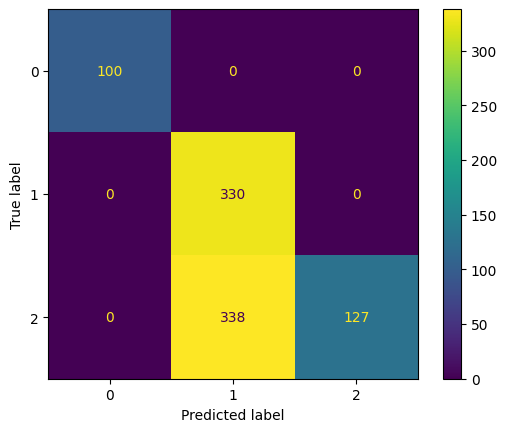

In [274]:
# Testing and visualising our random forest
print('Accuracy : ',accuracy_score(Y_test.detach().cpu().numpy(),y_pred))
cm = confusion_matrix(Y_test.detach().cpu().numpy(), y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

The accuracy score is good, and the confusion matrix gives us some interesting insight : the model classifies healthy patients and patients suffering from RA correctly everytime. However, the random forest missclassifies some of the 2(RA) dataset as 1 (SLE). This probably has to do with the high amount of features of the dataset that remain. 

Index(['GET4', 'MIA2', 'ALDOA', 'COX20', 'SMN2', 'ATP1A1-AS1', 'PYURF',
       'BOLA2B', 'U2AF1', 'WDR83', 'RPL21P28', 'ARL2BP', 'TTLL3', 'SULT1A3',
       'MGAT2', 'KRR1', 'HCG25', 'LINC02067', 'MATR3', 'BCL2L2-PABPN1',
       'LIX1L-AS1', 'ERCC5', 'SNX32', 'PINK1-AS', 'EIF3CL', 'TRNT1',
       'MIR1244-2', 'MIR3655', 'HNRNPA1P10', 'EIF3C', 'CYP51A1', 'MIR3661',
       'MIR5047', 'MRPL53', 'MIR1244-3', 'SMN1', 'HIF1A-AS2', 'ARG2',
       'EZR-AS1', 'THTPA', 'MIR7847', 'POLR2J2', 'MIR7703', 'NUDT4P2', 'RBM34',
       'GTF2IP1', 'MTRF1L', 'CHRNB2', 'MIR4721', 'ZC3H11A', 'SMG1P2',
       'MED4-AS1', 'MIR497HG', 'SNORA67', 'CNTD1', 'UXT-AS1', 'TSPOAP1-AS1',
       'NPIPB12', 'PCBP2-OT1', 'FEM1A', 'B3GNT4', 'EGLN2', 'CD2', 'SLX1B',
       'NBPF10', 'CCZ1B', 'MIR6848', 'SNURF', 'SLC16A3', 'MIR6852', 'CCZ1',
       'MIF-AS1', 'STAG3L1', 'WDR73', 'SNX22', 'LRRC75A', 'LRTOMT', 'SLC7A6OS',
       'DDX47', 'SETD6', 'SNORD50B', 'HSPA14', 'AP3S2', 'PKD1P1', 'MIR5193',
       'SAMD1', 'MIF', 'SLX1A

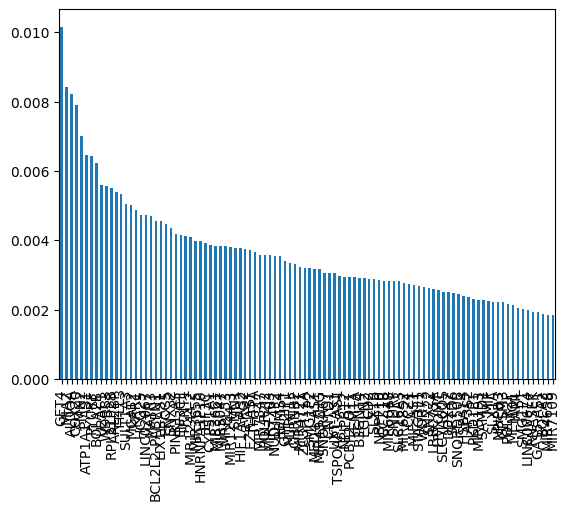

In [275]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf.feature_importances_, index=normalized_train_data.iloc[:,:-1].columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances[:100].plot.bar();
feature_importances.iloc[:100].index

Let's try something new : we will keep the 50 most significant features from our RF, and try to see if the classification gets better when restricting our dataset to only these 50 columns. \
Keep in mind that this method is not perfect : we obtained the 50 features using a flawed dataset that tends to get our RF to missclassify. However, 50 features should be enough to mitigate this imperfection.

In [276]:
best_features =['BCL2L2-PABPN1', 'EIF3CL', 'U2AF1', 'GET4', 'SMG1P1', 'MIR7703',
       'GTF2IP1', 'MATR3', 'RBM34', 'SNX32', 'HNRNPA1P10', 'MIR3661', 'ARL2BP',
       'VRK2', 'RPL21P28', 'WDR83', 'MIR1244-2', 'BOLA2', 'ARG2', 'SMN2',
       'SNURF', 'PYURF', 'PINK1-AS', 'DDX47', 'BOLA2B', 'MIA2', 'HBB', 'MIF',
       'POLR2F', 'SULT1A4', 'CHRNB2', 'SULT1A3', 'MEMO1', 'LIX1L-AS1',
       'LINC00674', 'COX20', 'ZC3H11A', 'NPIPB3', 'SMG1P5', 'NOMO3', 'SNORD81',
       'MIR6848', 'TATDN1', 'SLX1A', 'HCG25', 'GRAMD1A', 'HIF1A-AS2',
       'MIR5047', 'AP3S2', 'MIR3655', 'MIR4761', 'MIR3064', 'ATP1A1-AS1',
       'FEM1A', 'NBPF10', 'LINC02067', 'B3GNT4', 'EIF3C', 'SNORA31',
       'TSPOAP1-AS1', 'MEF2B', 'ALDOA', 'CNTD1', 'STARD5', 'SPAG5-AS1',
       'SLC16A3', 'PHKG1', 'MGAT2', 'RNASEK', 'SNORD31', 'MIR7109', 'CCZ1B',
       'ACTR1A', 'ERCC5', 'MLLT6', 'NSFP1', 'TFE3', 'SNORD50B', 'SAMD1',
       'ARG1', 'CD4', 'MIR7847', 'EZR-AS1', 'POLR2J2', 'MIR1244-3', 'MIF-AS1',
       'NUDT4P2', 'SLX1B', 'KRR1', 'GNL3L', 'MRPL53', 'SYNGAP1', 'NKIRAS1',
       'GAS5-AS1', 'BORCS8', 'STAG3L1', 'UBE2Q1-AS1', 'SMN1', 'RASA4','SNORD104']
best_features.append('label')
normalized_test_data.loc[:,best_features]
normalized_train_data.loc[:,best_features]

X_train, Y_train = dataToTensor(normalized_train_data)
X_train=X_train.to(device)
Y_train= Y_train.to(device)
X_test, Y_test = dataToTensor(normalized_test_data)
X_test=X_test.to(device)
Y_test=Y_test.to(device)

In [277]:
# Implementing a random forest 
rf = RandomForestClassifier(max_depth=14,n_estimators=484,class_weight=class_weight_dict) # see below for hyperparameter tuning
rf.fit(X_train.detach().cpu().numpy(), Y_train.detach().cpu().numpy())
y_pred= rf.predict(X_test.detach().cpu().numpy())

Accuracy :  0.6268156424581005


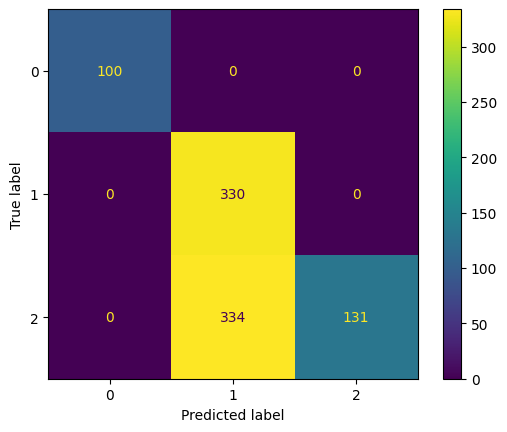

In [278]:
# Testing and visualising our random forest
print('Accuracy : ',accuracy_score(Y_test.detach().cpu().numpy(),y_pred))
cm = confusion_matrix(Y_test.detach().cpu().numpy(), y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [ ]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf.feature_importances_, index=normalized_train_data.iloc[:,:-1].columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances[:10].plot.bar();
feature_importances.iloc[:10].index

In [279]:
# # Hyperparameters tuning 
# param_dist = {'n_estimators': randint(300,500),
#               'max_depth': randint(1,20)}
# # Use random search to find the best hyperparameters
# rand_search = RandomizedSearchCV(rf, 
#                                  param_distributions = param_dist, 
#                                  n_iter=10, 
#                                  cv=5)

# # Fit the random search object to the data
# rand_search.fit(X_train.detach().cpu().numpy(), Y_train.detach().cpu().numpy())
# # Create a variable for the best model
# best_rf = rand_search.best_estimator_

# # Print the best hyperparameters
# print('Best hyperparameters:',  rand_search.best_params_)



# Model designing and training

First, we will use a NN to predict diagnoses efficiently. We will then implement a random forest to try to interprete our classified omics data. 

In [280]:
## Defining our nn model class
class ClassificationModel(nn.Module):
    def __init__(self,input_features:int,output_features:int):
        super().__init__()
        self.layers=nn.Sequential(nn.Linear(in_features=input_features,out_features=HIDDEN_UNITS,device=device),
                              nn.ReLU(),
                              nn.Linear(in_features=HIDDEN_UNITS,out_features=HIDDEN_UNITS,device=device),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(in_features=HIDDEN_UNITS,out_features=HIDDEN_UNITS,device=device),
                              nn.ReLU(),
                              nn.Linear(in_features=HIDDEN_UNITS,out_features=output_features,device=device)
                              )
    def forward(self,x):
        return self.layers(x)   

model=ClassificationModel(input_features=len(X_train[1]),output_features=CLASSES).to(device)

In [281]:
## Neural Network functions
loss_fn=nn.CrossEntropyLoss(weight=torch.tensor(class_weights,dtype=torch.float32).to(device))
optimizer=torch.optim.SGD(model.parameters(),LEARNING_RATE,WEIGHT_DECAY)
def accuracy_fn(y_true, y_pred): 
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

In [ ]:
## Training

for epoch in range(EPOCHS):
    model.train()
    y_logits=model(X_train).to(device)
    y_pred=torch.argmax(input=y_logits,dim=1).to(device)
    loss = loss_fn(y_logits, Y_train)
    acc = accuracy_fn(y_true=Y_train,y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ##Testing

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1).to(device)
        test_loss = loss_fn(test_logits,Y_test)
        test_acc = accuracy_fn(Y_test,test_pred)
    if epoch%10==0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 
    if epoch ==199:
        f1score= F1Score(task="multiclass", num_classes=3).to(device)
        f1score.update(y_pred,Y_train)
        f1score=f1score.compute()
        print(f'\nFinal F1 Score : {f1score}')

Epoch: 0 | Loss: 1.08777, Acc: 43.68% | Test Loss: 1.09811, Test Acc: 36.87%
Epoch: 10 | Loss: 1.08865, Acc: 44.12% | Test Loss: 1.09806, Test Acc: 36.87%
Epoch: 20 | Loss: 1.08614, Acc: 44.83% | Test Loss: 1.09795, Test Acc: 36.87%
Epoch: 30 | Loss: 1.08655, Acc: 45.51% | Test Loss: 1.09781, Test Acc: 36.87%
Epoch: 40 | Loss: 1.08476, Acc: 45.51% | Test Loss: 1.09762, Test Acc: 36.87%
Epoch: 50 | Loss: 1.08406, Acc: 46.07% | Test Loss: 1.09740, Test Acc: 36.87%
Epoch: 60 | Loss: 1.08349, Acc: 46.85% | Test Loss: 1.09715, Test Acc: 36.87%
Epoch: 70 | Loss: 1.08132, Acc: 47.59% | Test Loss: 1.09690, Test Acc: 36.87%
Epoch: 80 | Loss: 1.08089, Acc: 47.41% | Test Loss: 1.09667, Test Acc: 36.87%
Epoch: 90 | Loss: 1.07814, Acc: 48.25% | Test Loss: 1.09639, Test Acc: 36.87%
Epoch: 100 | Loss: 1.07923, Acc: 48.34% | Test Loss: 1.09611, Test Acc: 36.87%
Epoch: 110 | Loss: 1.07838, Acc: 48.25% | Test Loss: 1.09583, Test Acc: 36.87%
Epoch: 120 | Loss: 1.07790, Acc: 48.71% | Test Loss: 1.09556, T

Our NN model is pretty bad at predicting output, with a low test accuracy. There to be some overfitting as the test accuracy keeps decreasing while train accuracy keeps increasing. With some further hyperparameters tuning and slight modifications to the model, we could probably improve this.
The most important factor is probably the amount of features that is too big for such a small number of samples. With more time, we could remedy this by implementing factor selection, such as PCA or RFE.

Now, we will interpret the data using a random forest classifier.

I ran this and got "Best hyperparameters: {'max_depth': 14, 'n_estimators': 484}". The computational time is quite long, and it could be improved further. 